In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

2024-04-14 10:38:38.313862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 10:38:39.487395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [5]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [6]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))


Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [7]:
# Create dictionary of target classes
label_dict = {
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
}


Text(0.5, 1.0, '(Label: 3)')

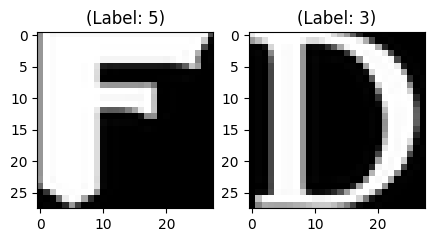

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


In [9]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [11]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)


In [15]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))


In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='random_normal')(up2) # 28 x 28 x 1
    return decoded


In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


2024-04-14 10:38:42.846252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 10:38:42.919063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 10:38:42.919415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 10:38:42.922632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 10:38:42.922949: I external/local_xla/xla/stream_executor

In [18]:
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,625 (1.20 MB)

 Trainable params: 314,625 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/50


I0000 00:00:1713116324.834659   23726 service.cc:145] XLA service 0x7f2490007fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713116324.835206   23726 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-14 10:38:44.871928: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-14 10:38:45.004268: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 36/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1676

I0000 00:00:1713116327.082738   23726 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0732 - val_loss: 0.0191
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0119 - val_loss: 0.0099
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

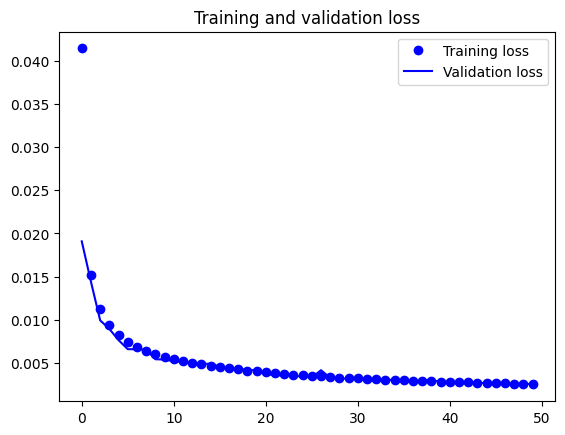

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
pred = autoencoder.predict(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [22]:
pred.shape

(10000, 28, 28, 1)

Test Images


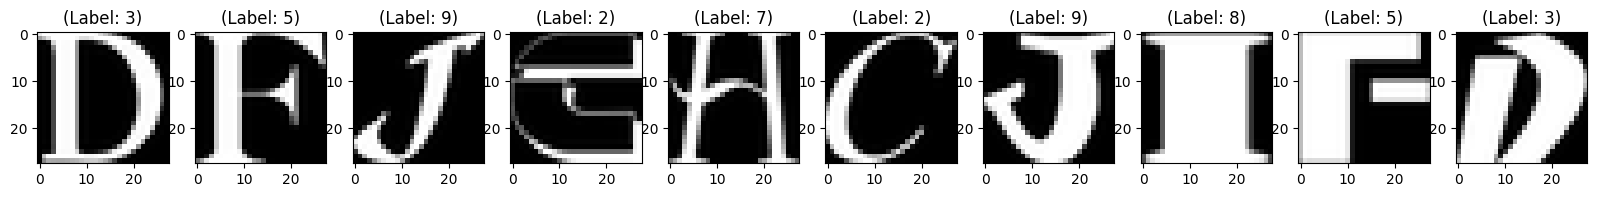

Reconstruction of Test Images


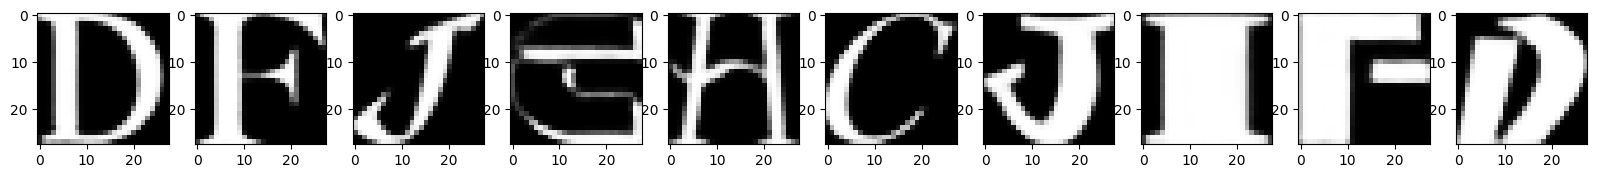

In [23]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [24]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

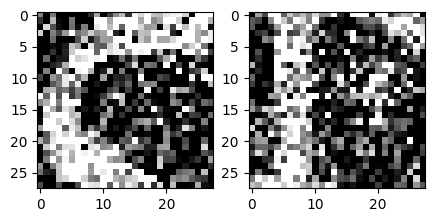

In [25]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [26]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [27]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded


In [28]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


In [29]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1035 - val_loss: 0.0349
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0324 - val_loss: 0.0272
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0264 - val_loss: 0.0224
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0236 - val_loss: 0.0223
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0221 - val_loss: 0.0210
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0209 - val_loss: 0.0204
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0201 - val_loss: 0.0200
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0197 - val_loss: 0.0195
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0187 - val_loss: 0.0192
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0186 - val_loss: 0.0179
Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

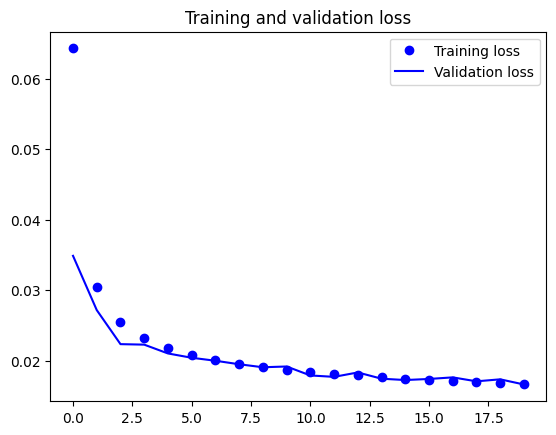

In [30]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [31]:
pred = autoencoder.predict(x_test_noisy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [32]:
print(pred[0])

[[[8.49986911e-01]
  [9.45360184e-01]
  [9.57426727e-01]
  [9.68413949e-01]
  [9.76992249e-01]
  [9.82487857e-01]
  [9.83302534e-01]
  [9.80921388e-01]
  [9.69891727e-01]
  [9.54884291e-01]
  [9.61669683e-01]
  [9.61197078e-01]
  [9.57740068e-01]
  [9.47325170e-01]
  [9.15515721e-01]
  [8.33816648e-01]
  [5.93879223e-01]
  [2.50679880e-01]
  [6.86011389e-02]
  [2.57003605e-02]
  [1.35185719e-02]
  [8.62814672e-03]
  [4.44040680e-03]
  [2.82249739e-03]
  [1.97321363e-03]
  [2.32487288e-03]
  [4.58129309e-03]
  [1.42800082e-02]]

 [[6.83618188e-01]
  [8.49483430e-01]
  [9.00662303e-01]
  [9.60572898e-01]
  [9.90111411e-01]
  [9.96078074e-01]
  [9.96811807e-01]
  [9.90891993e-01]
  [9.37556922e-01]
  [7.32968688e-01]
  [6.46252215e-01]
  [6.83965027e-01]
  [7.59098470e-01]
  [8.94286990e-01]
  [9.47861791e-01]
  [9.77811992e-01]
  [9.64943945e-01]
  [9.06567037e-01]
  [6.71445847e-01]
  [2.45889142e-01]
  [5.80182858e-02]
  [1.29696168e-02]
  [2.75735604e-03]
  [1.03859196e-03]
  [6.55019

Test Images


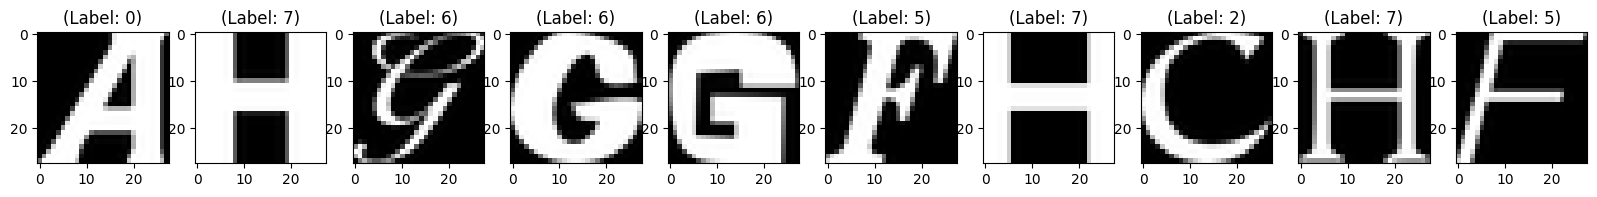

Test Images with Noise


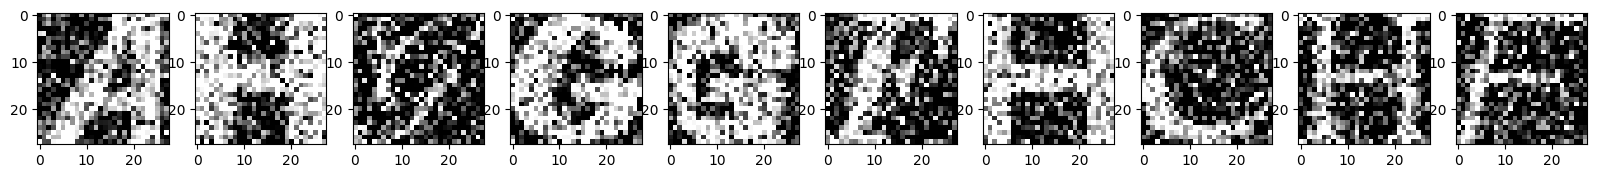

Reconstruction of Noisy Test Images


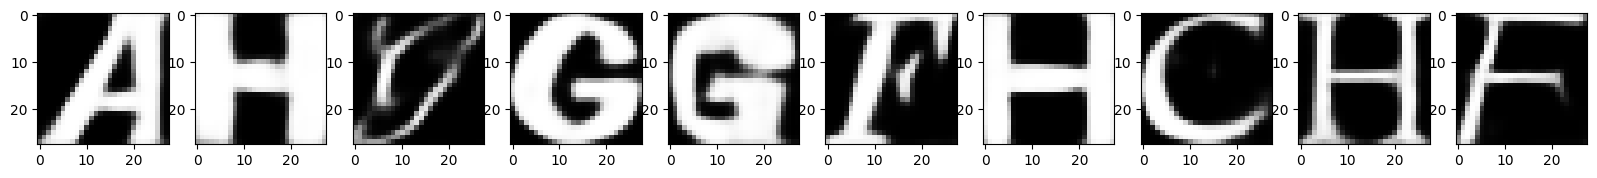

In [33]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()


In [34]:
for layer in autoencoder.layers:
    print(layer.get_config(), layer.get_weights())

{'batch_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'} []
{'name': 'conv2d_6', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[[-0.04906792,  0.17564614, -0.16459481,  0.08337402,
          -0.17926218,  0.03346399, -0.0216491 , -0.011179  ,
           0.0054917 ,  0.23496385, -0.05329143, -0.01661462,
          -0.02572529, -0.11896966, -0.2020905 , -0.08869071,
           0.07